## Checking datasets have been preprocessed correctly

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
from twaidata.MRI_preprep.io import load_nii_img
from twaidata.mri_dataset_directory_parsers.MSS3_multirater import MSS3MultiRaterDataParser
from twaidata.mri_dataset_directory_parsers.LBC_multirater import LBCMultiRaterDataParser
from twaidata.mri_dataset_directory_parsers.WMHChallenge_Unified import WMHChallengeInterRaterDirParser
from twaidata.mri_dataset_directory_parsers.EdData import EdDataParser
from twaidata.mri_dataset_directory_parsers.from_text_file import FromFileParser
from twaidata.mri_dataset_directory_parsers.MSSEG import MSSEGDirParser
from tqdm import tqdm

In [26]:
img = load_nii_img("/home/s2208943/preprocessed_data/MSS3_InterRaterData/imgs/MSS3_ED_001_V3_T1.nii.gz")
# img = load_nii_img("/home/s2208943/MSS3_001/V1/MSS3_ED_001_V1_T1Wbrain.nii.gz")
# img = load_nii_img("/home/s2208943/ipdis/data/InterRater_data/LBC360007/LBC360007_1_T1brain_reg_T2.nii.gz")

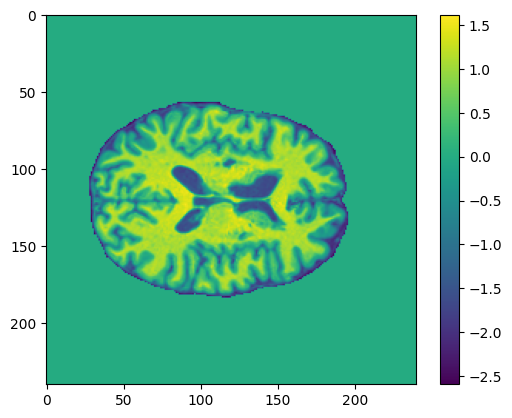

In [27]:
plt.imshow(img[0][:,:,30])
plt.colorbar()

In [28]:
# NOTE TO SELF there is a bug in the preprocessing code such that the T1 is not being normalized properly, then its causing some kind of error and then skipping to the next individual. I do not know quite why this is happening yet.

In [29]:
# parser = MSS3MultiRaterDataParser(
#         # paths on the cluster for the in house data
#         "/home/s2208943/datasets/Inter_observer",
#         "/home/s2208943/preprocessed_data/MSS3_InterRaterData"
#     )

# parser = LBCMultiRaterDataParser(
#         # paths on the cluster for the in house data
#         "/home/s2208943/datasets/Inter_observer",
#         "/home/s2208943/preprocessed_data/LBC_InterRaterData"
#     )

# parser = EdDataParser(
#     "/home/s2208943/datasets/CVD/mixedCVDrelease",
#     "/home/s2208943/preprocessed_data/Ed_CVD"
# )

# parser = WMHChallengeInterRaterDirParser(
#     "/home/s2208943/datasets/WMH_Challenge",
#     "/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData"
# )

# parser = FromFileParser(
#     "/home/s2208943/ipdis/WMH_UQ_assessment/twaidata/ADNI300_preprocessing/ADNI_300_preprocessing_io_table.csv",
#     "/home/s2208943/datasets/ADNI300/ADNI300_selected_data",
#     "/home/s2208943/preprocessed_data/ADNI300"
# )

# parser = MSSEGDirParser(
#         # paths on the cluster for the in house data
#         "/home/s2208943/datasets/MSSEG",
#         "/home/s2208943/preprocessed_data/MSSEG"
#     )

parser = FromFileParser(
    "/home/s2208943/ipdis/WMH_UQ_assessment/twaidata/ISLES2022_initial_preprocessing/ISLES2022_preprocessing_io_table.csv",
    "/home/s2208943/datasets/ISLES2022/ISLES-2022",
    "/home/s2208943/preprocessed_data/ISLES2022"
)
    
iomap = parser.get_dataset_inout_map()
for key, value in iomap.items():
    print("individual: ", key)
    print("individual map:", value)
    print(value.keys())
    break

sub-strokecase0001 FLAIR {'infile': '/home/s2208943/datasets/ISLES2022/ISLES-2022/sub-strokecase0001/ses-0001/anat/sub-strokecase0001_ses-0001_FLAIR_registered.nii.gz', 'outpath': '/home/s2208943/preprocessed_data/ISLES2022/imgs', 'outfilename': 'sub-strokecase0001_FLAIR', 'islabel': False}
sub-strokecase0001 ADC {'infile': '/home/s2208943/datasets/ISLES2022/ISLES-2022/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_adc.nii.gz', 'outpath': '/home/s2208943/preprocessed_data/ISLES2022/imgs', 'outfilename': 'sub-strokecase0001_ADC', 'islabel': False}
sub-strokecase0001 DWI {'infile': '/home/s2208943/datasets/ISLES2022/ISLES-2022/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_dwi.nii.gz', 'outpath': '/home/s2208943/preprocessed_data/ISLES2022/imgs', 'outfilename': 'sub-strokecase0001_DWI', 'islabel': False}
sub-strokecase0001 stroke {'infile': '/home/s2208943/datasets/ISLES2022/ISLES-2022/derivatives/sub-strokecase0001/ses-0001/sub-strokecase0001_ses-0001_msk.nii.g

In [30]:
### for each file, go through and check that the outfile exists
### if it does and it is not a label, check that it has been normalized
failures = 0
successes = 0
failed_keys = []
for key, filesmap in iomap.items():
    success = True
    for fn in filesmap.keys():
        img_path = os.path.join(filesmap[fn]['outpath'], filesmap[fn]['outfilename']) + ".nii.gz"
        if not os.path.exists(img_path):
            print(f"{key} missing {fn} file")
            success = False
        # else:
        #     if not filesmap[fn]['islabel']:
        #         img = load_nii_img(img_path)[0]
        #         mean = img.mean()
        #         std = img.std() # since most voxels are background, the std of the overall image will be less than 1
        #                         # if the image has been preprocessed correctly.
        #         print(mean, std)
            
    if not success:
        failures += 1
        failed_keys.append(key)
        
    else:
        successes += 1

print("failures: ", failures)
print("successes: ", successes)
print("failed keys: ", failed_keys)

failures:  0
successes:  250
failed keys:  []


In [7]:
from natsort import natsorted
def visualise_rater_files(name, filemap, colorbar=False):
    print("-------")
    print(name)
    num_imgs = len(filemap.keys())
    
    def get_img(key):
        try:
            return load_nii_img(os.path.join(filemap[key]['outpath'], filemap[key]['outfilename'] + ".nii.gz"))[0]
        except:
            print(f"failed for {key}")
            return None
    
    imgs = {key: get_img(key) for key in tqdm(natsorted(list(filemap.keys())))}
    
    fig, axs = plt.subplots(3, num_imgs, figsize=(20, 10))
    
    print(imgs.keys())
    # print(imgs)
    num_slices = imgs['FLAIR'].shape[-1]
    islices = [num_slices // 4, num_slices // 2, (num_slices // 4) * 3]
    for i in range(3):
        for j, key in enumerate(imgs.keys()):
            ax = axs[i][j]
            if imgs[key] is not None:
                im = ax.imshow(imgs[key][:,:,islices[i]], cmap='viridis')
                if i == 0:
                    ax.set_title(key)
                if colorbar:
                    plt.colorbar(im, ax=ax)
                
    plt.show()
    plt.clf()

-------
sub-strokecase0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.08it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


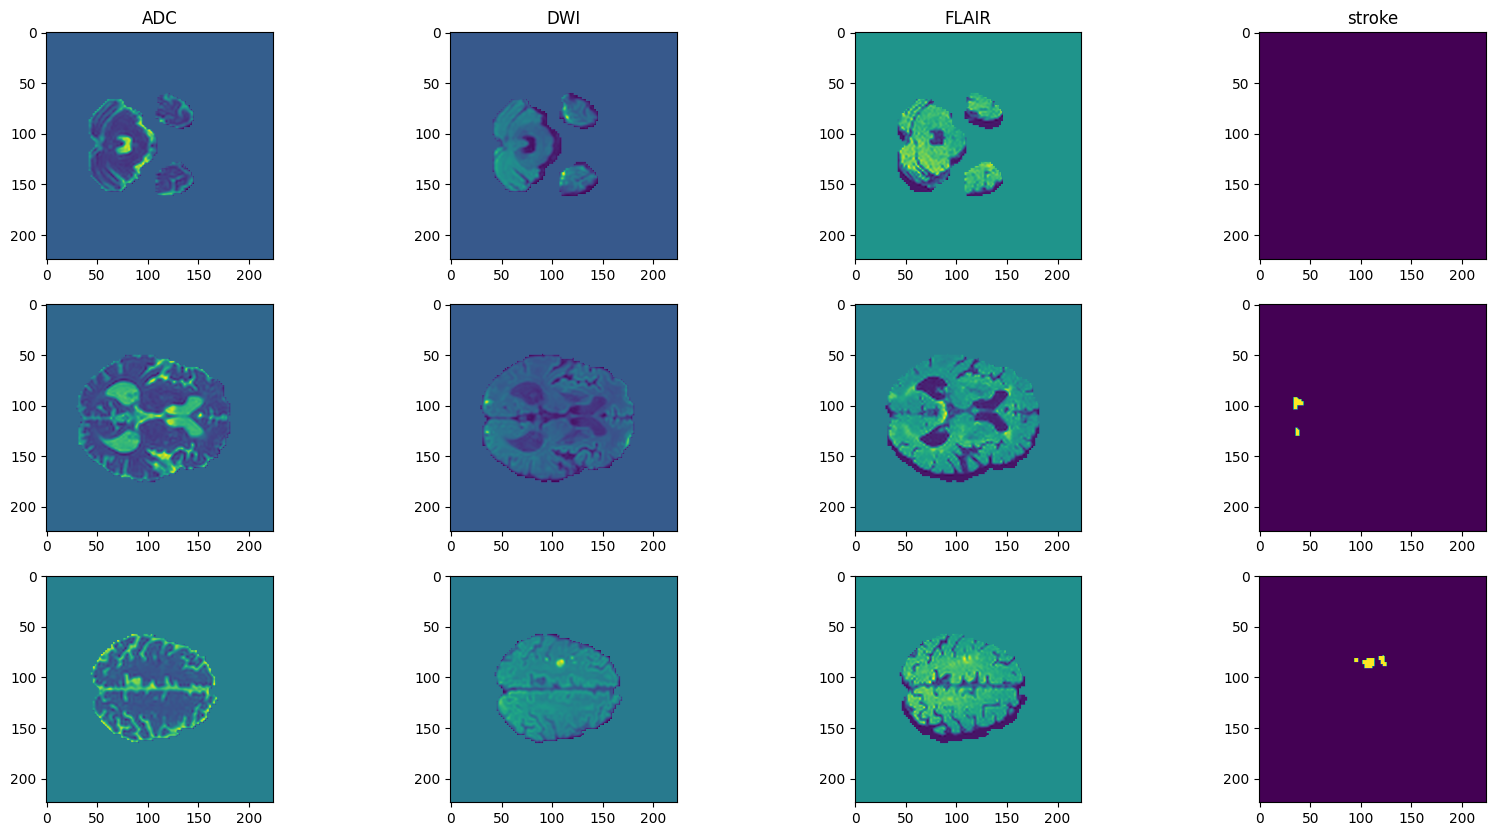

-------
sub-strokecase0002


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.36it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


<Figure size 640x480 with 0 Axes>

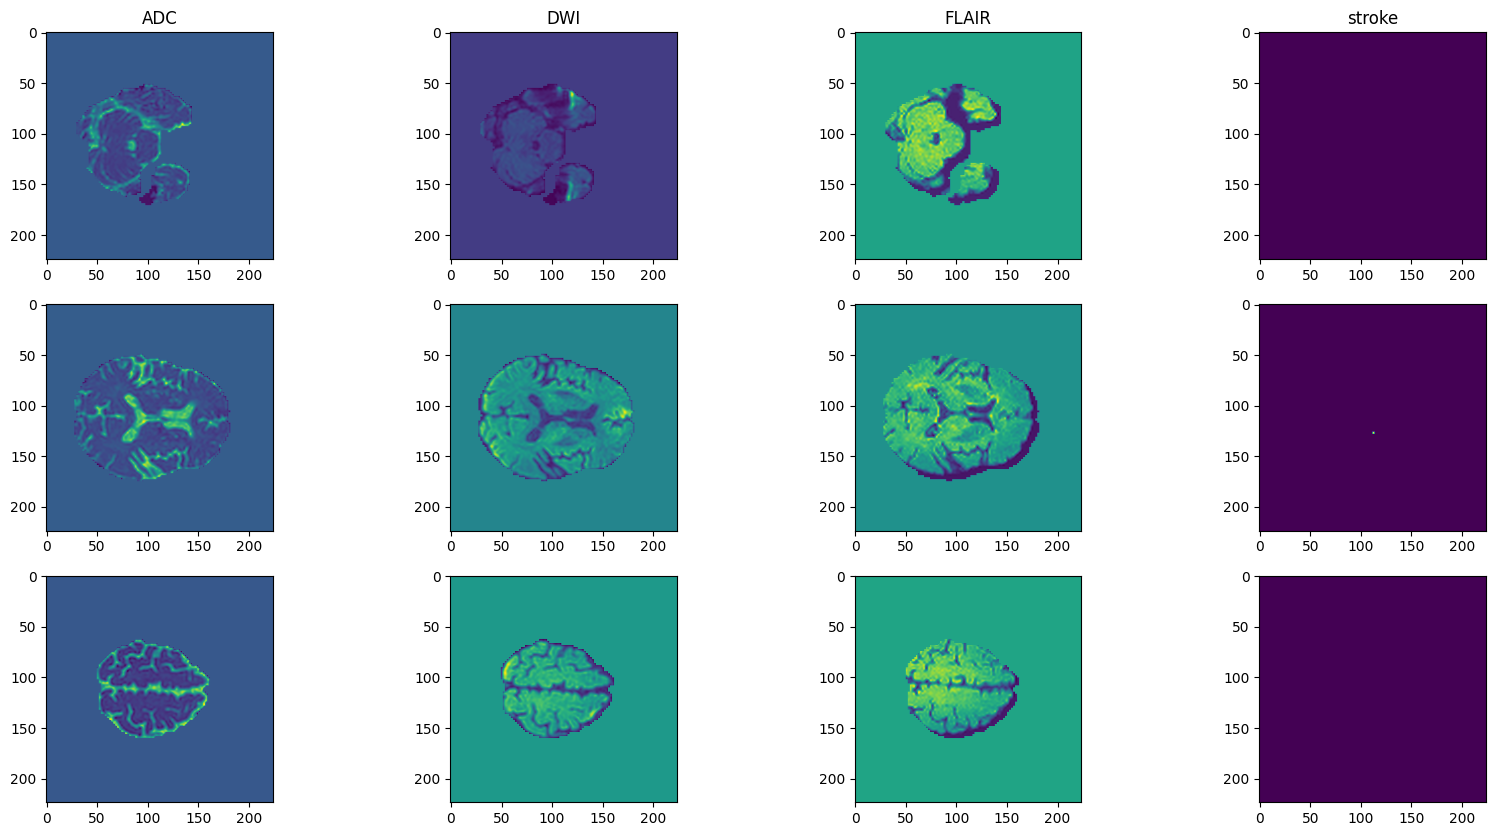

-------
sub-strokecase0003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.83it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


<Figure size 640x480 with 0 Axes>

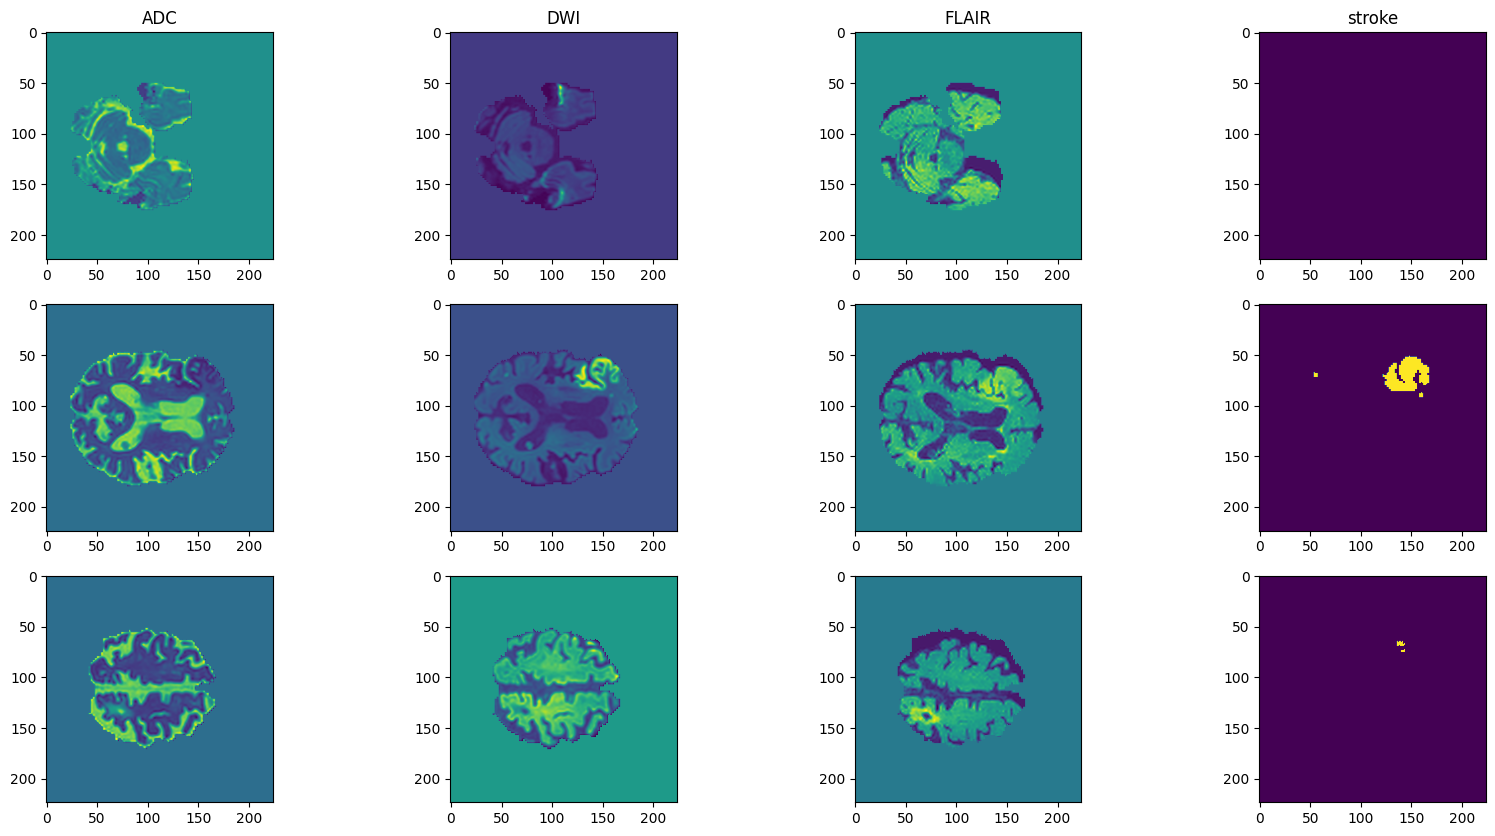

-------
sub-strokecase0004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.01it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


<Figure size 640x480 with 0 Axes>

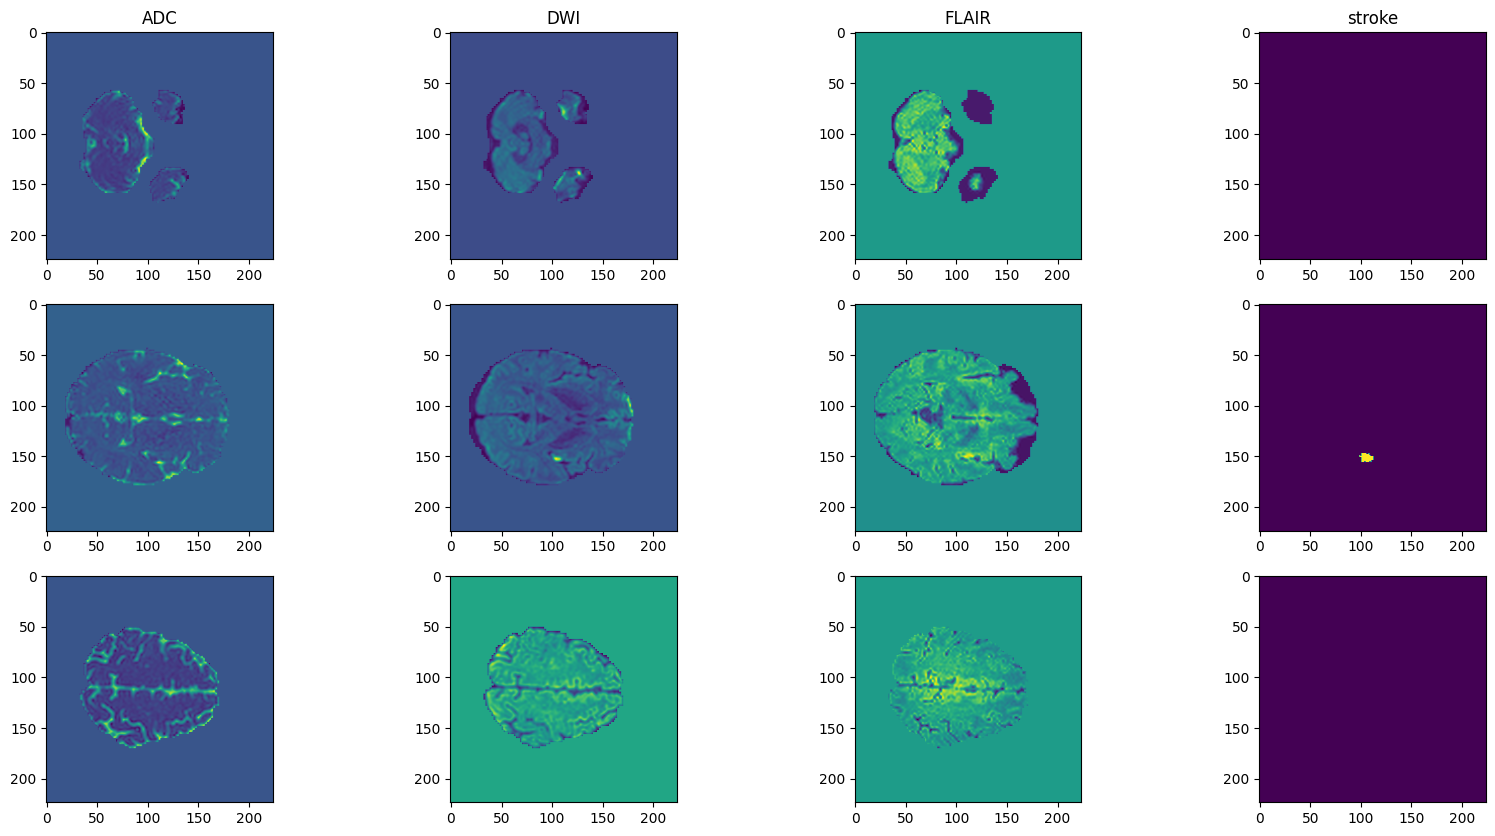

-------
sub-strokecase0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.30it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


<Figure size 640x480 with 0 Axes>

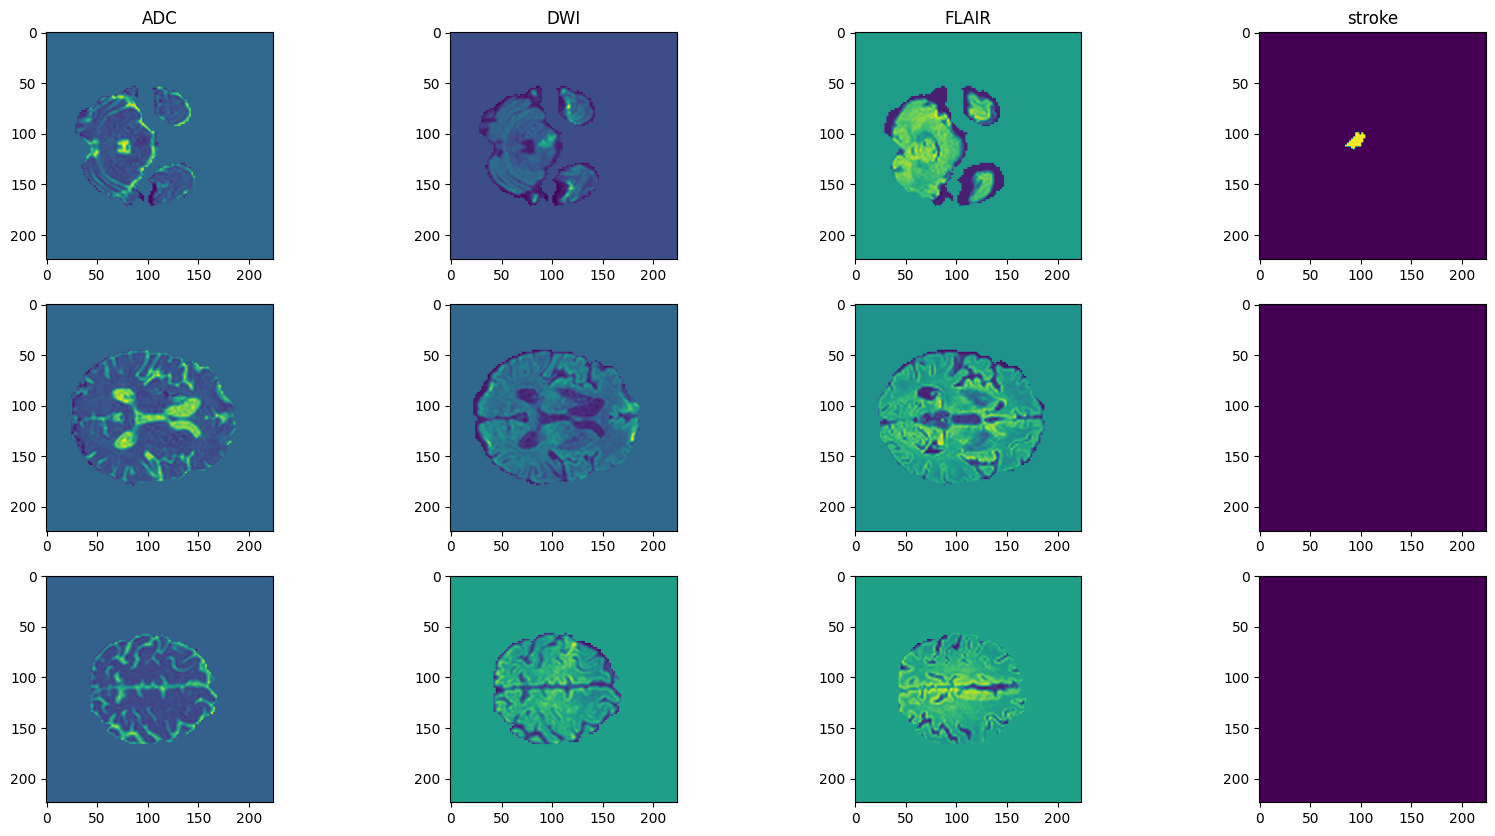

-------
sub-strokecase0006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.59it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


<Figure size 640x480 with 0 Axes>

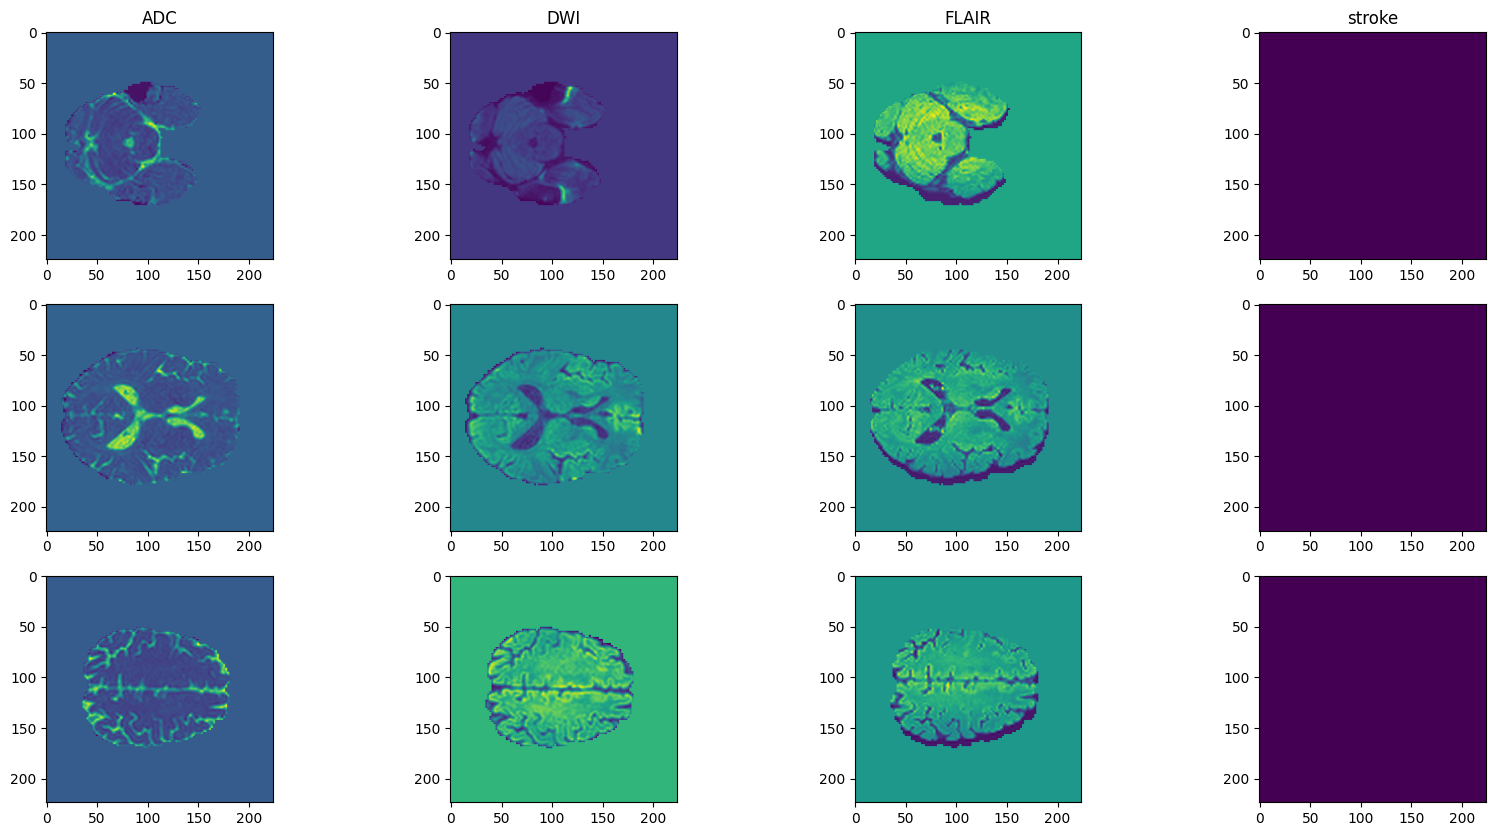

-------
sub-strokecase0007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.39it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


<Figure size 640x480 with 0 Axes>

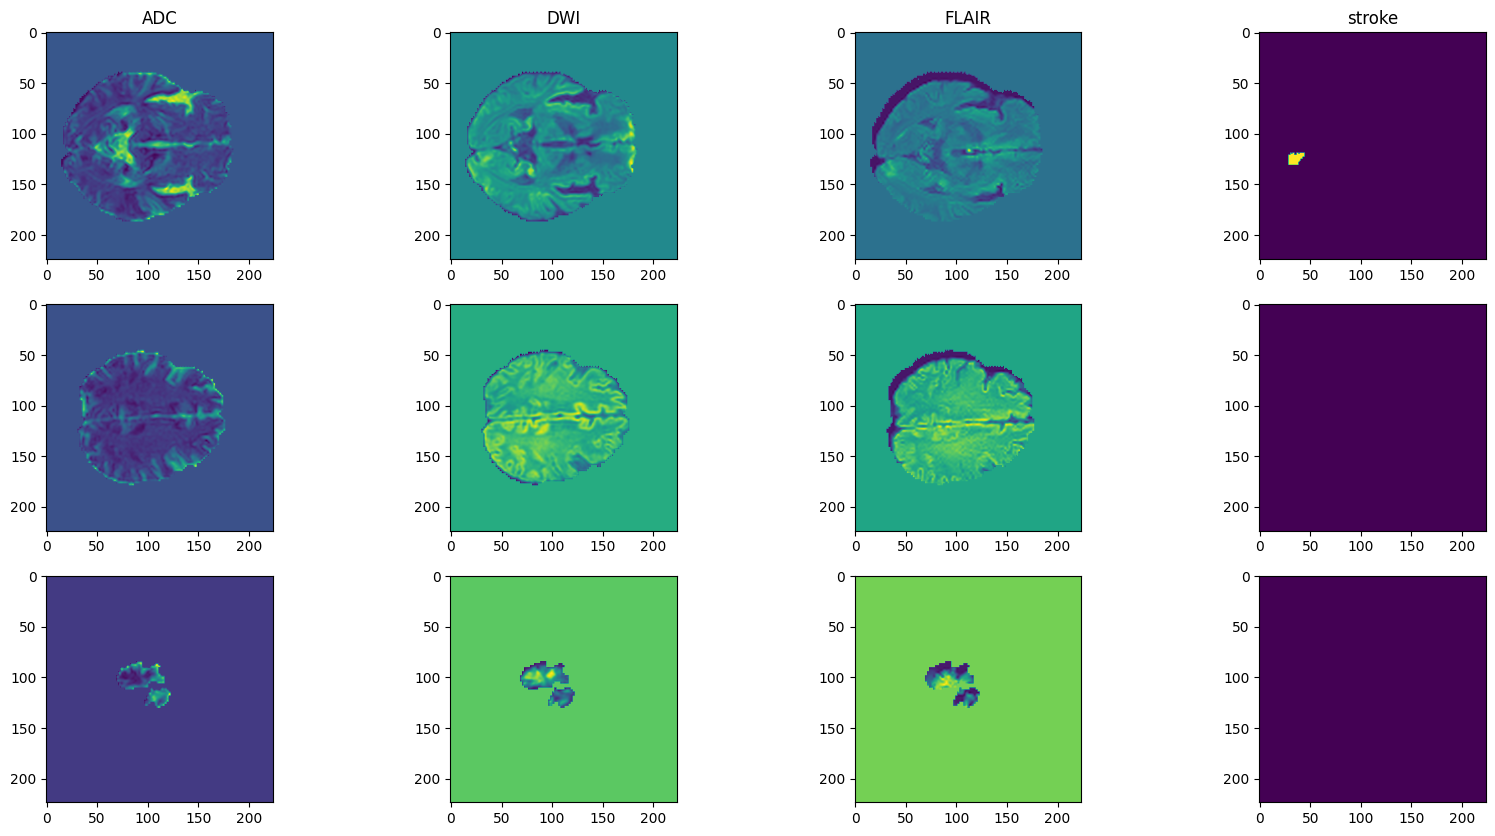

-------
sub-strokecase0008


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.59it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


<Figure size 640x480 with 0 Axes>

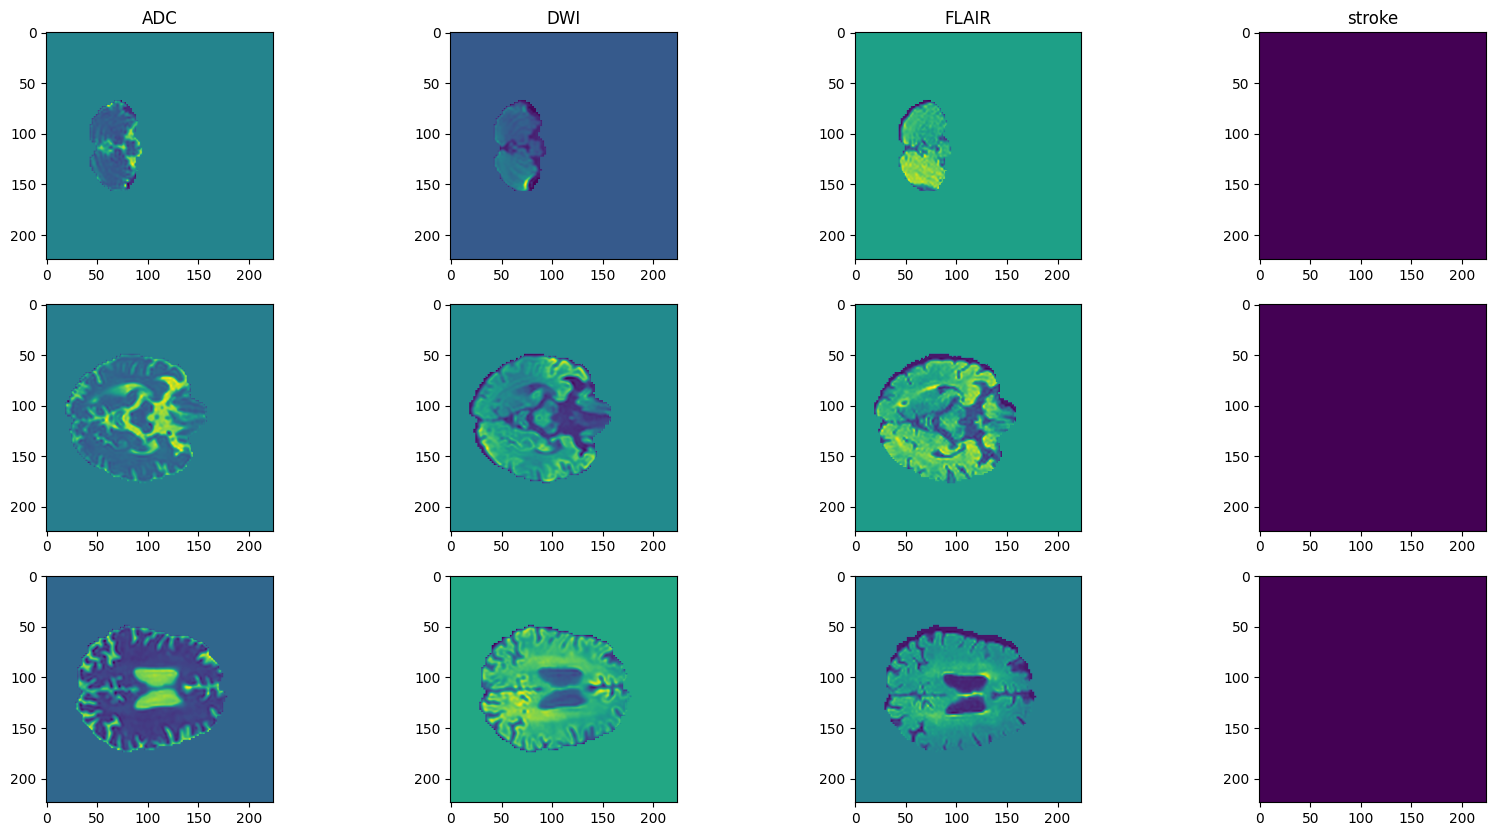

-------
sub-strokecase0009


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


<Figure size 640x480 with 0 Axes>

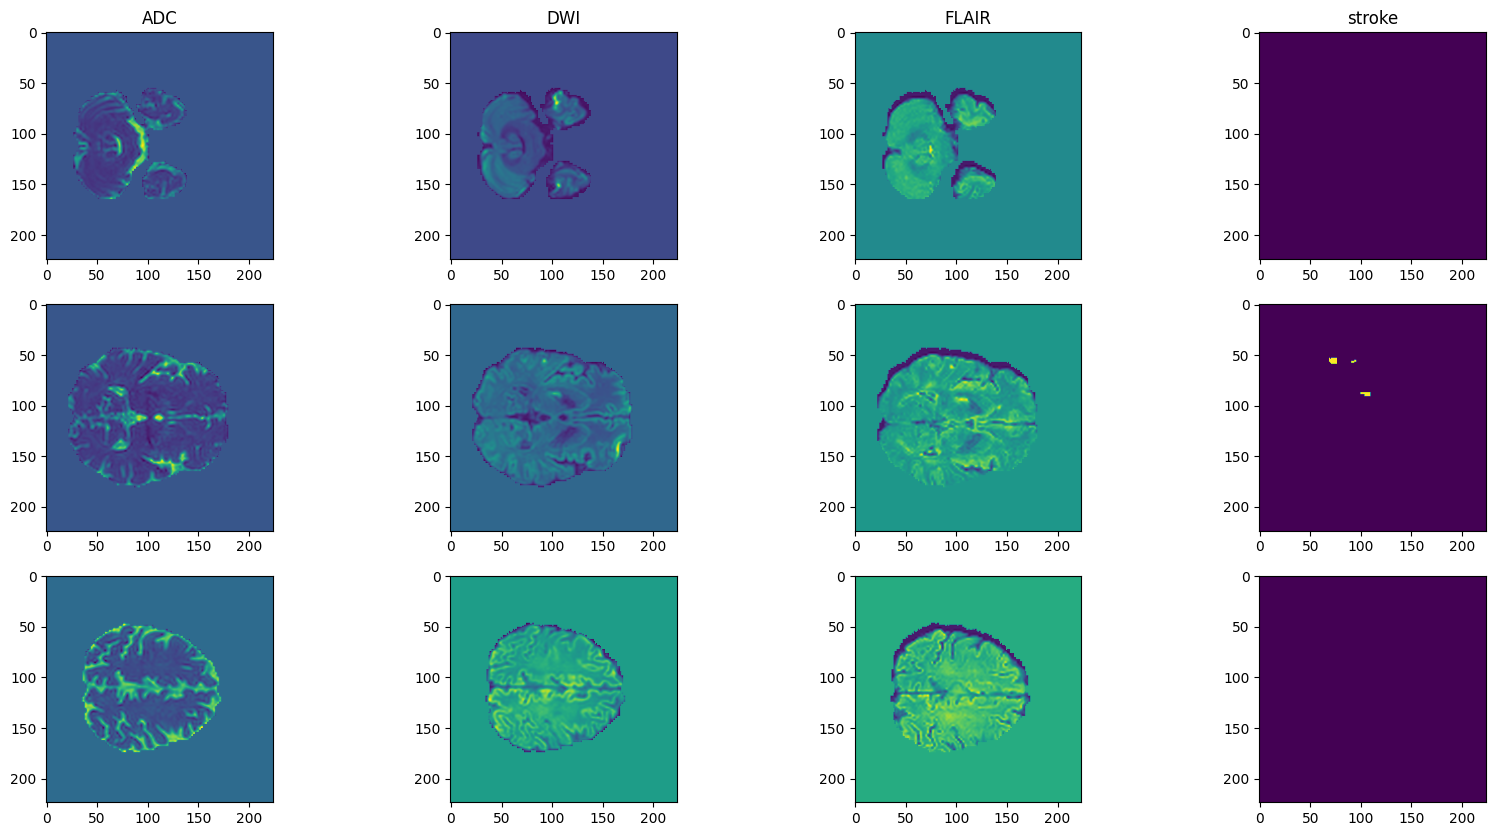

-------
sub-strokecase0010


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.00it/s]


dict_keys(['ADC', 'DWI', 'FLAIR', 'stroke'])


<Figure size 640x480 with 0 Axes>

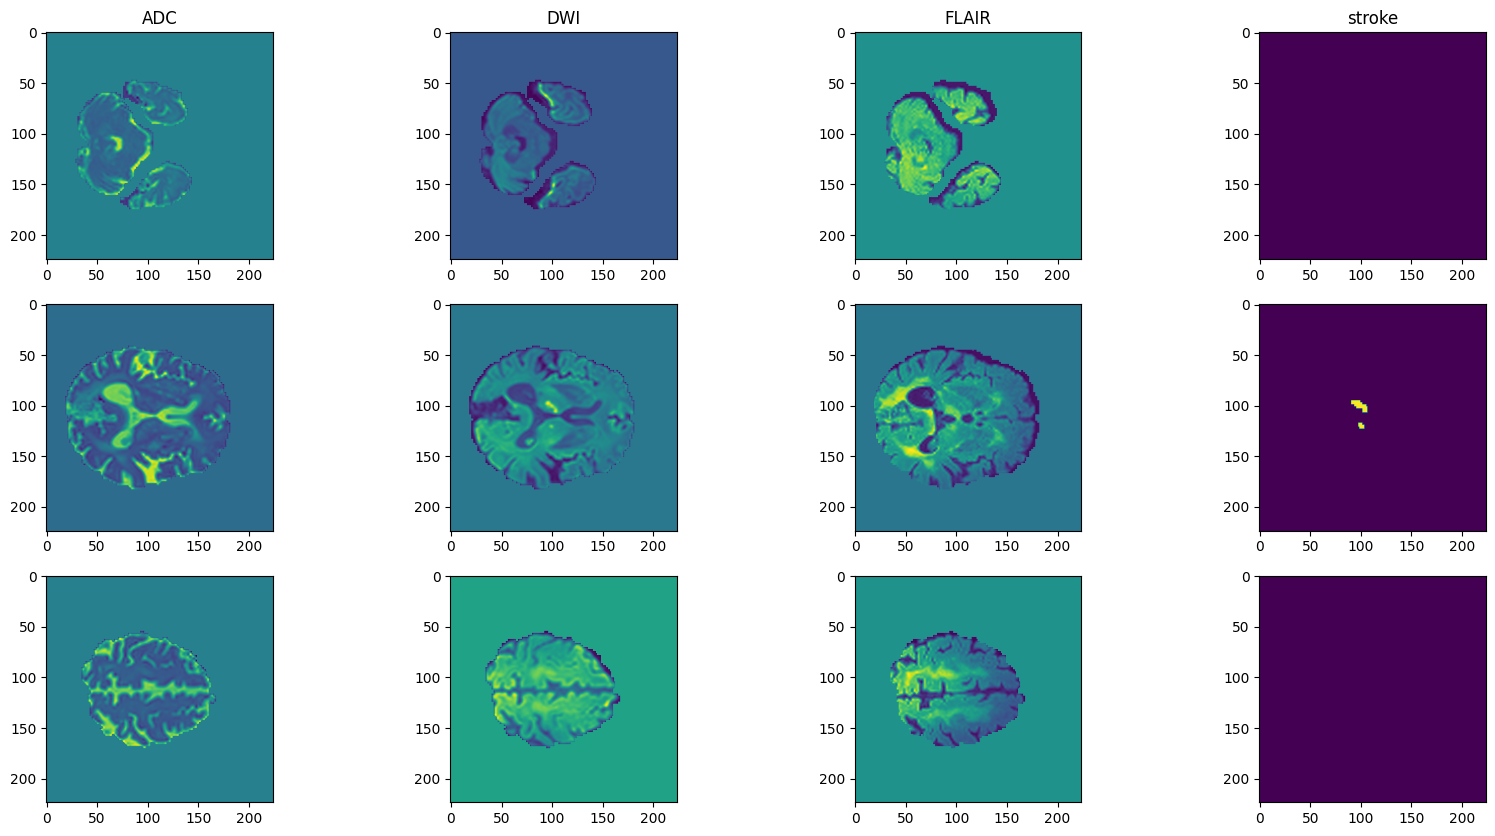

In [ ]:
for ind, filemap in iomap.items():
    visualise_rater_files(ind, filemap, colorbar=False)
    input()

In [5]:
parser = LBCMultiRaterDataParser(
        # paths on the cluster for the in house data
        "/home/s2208943/ipdis/data/InterRater_data",
        "/home/s2208943/ipdis/data/preprocessed_data/LBC_InterRaterData"
    )
    
iomap = parser.get_dataset_inout_map()

-------
LBC1921_21746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.98it/s]


dict_keys(['FLAIR', 'T1', 'wmh1', 'wmh2', 'wmh4', 'wmh5'])


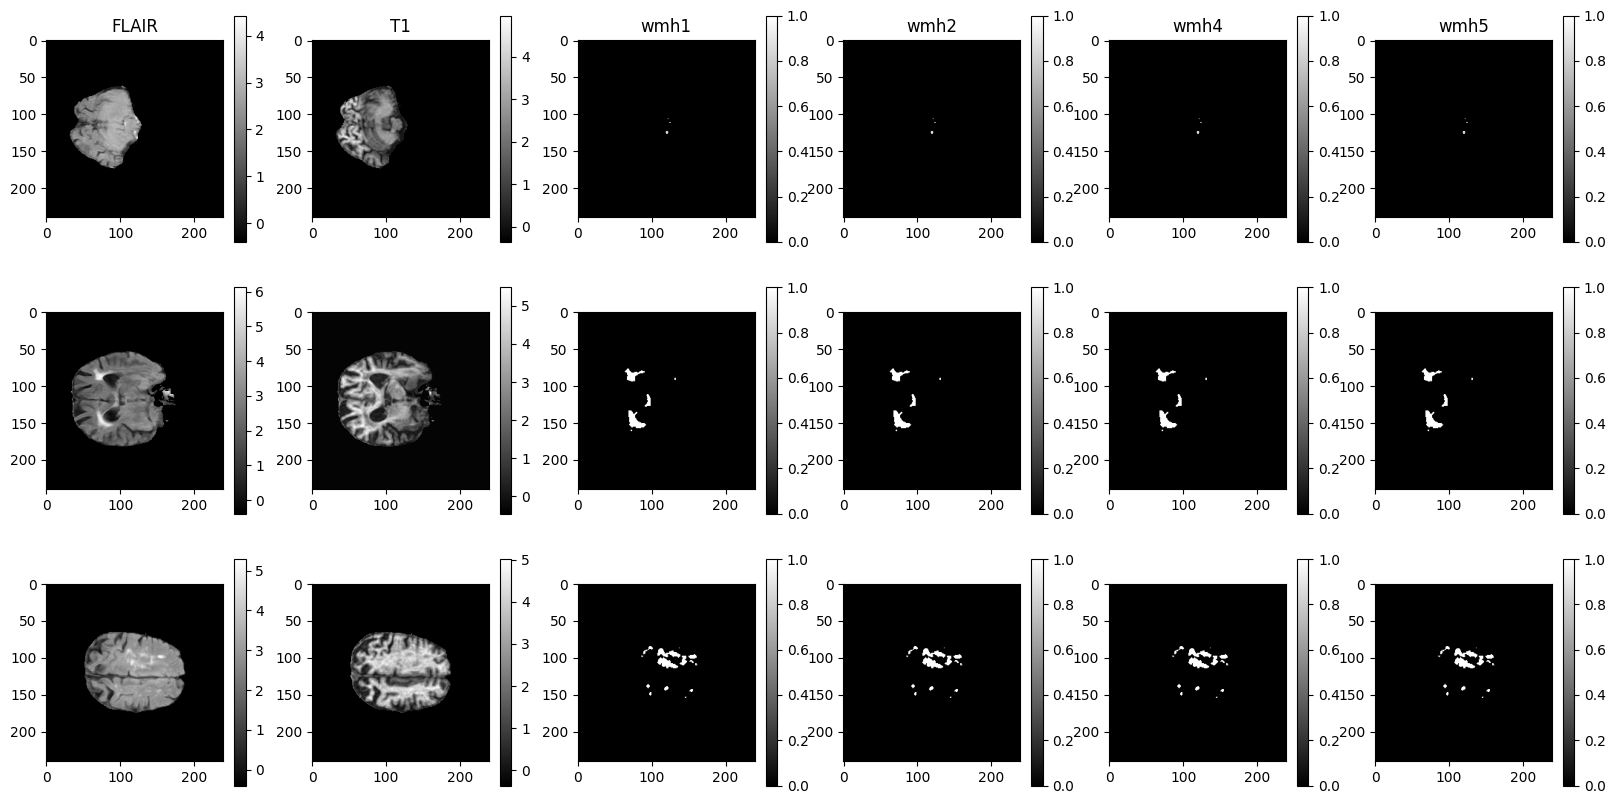

<Figure size 640x480 with 0 Axes>

In [6]:
for ind, filemap in iomap.items():
    try:
        visualise_rater_files(ind, filemap, colorbar=True)
    except:
        print(f"failed for {ind}")
        continue
    # input()
    break

In [ ]:
###